In [1]:
import pandas as pd

from src.algorithms.alternating_least_squares import AlternatingLeastSquares
from src.helpers.dataset_indexer import DatasetIndexer
from src.helpers.checkpoint_manager import CheckpointManager
from src.recommenders import CollaborativeFilteringRecommenderBuilder
from src.backends import Backend
from src.helpers._logging import logger  # noqa
from src.settings import settings

from src.helpers.graphing import (
    plot_als_train_test_loss_evolution,
    plot_als_train_test_rmse_evolution,
    plot_error_evolution,
    plot_power_low_distribution,
    plot_data_item_distribution_as_hist,
)

In [2]:
dataset_indexer = DatasetIndexer(
    file_path="./ml-32m/ratings.csv",
    user_header="userId",
    item_header="movieId",
    rating_header="rating",
    limit=settings.general.LINES_COUNT_TO_READ,
)

indexed_data = dataset_indexer.index(
    approximate_train_ratio=settings.general.APPROXIMATE_TRAIN_RATIO
)

2025-01-06 03:54:04,555 [WARNING] The current implementation does not split the data into train and test sets exactly with the provided ratio. We use the provided ratio as a probability for a Bernoulli distribution to know whether the data point should be used as a training data or a test data.
2025-01-06 03:54:12,152 [WARNING] The limit of lines (.i.e 1000000) to index has been reached. Exiting without loading the rest... 
2025-01-06 03:54:12,153 [INFO] Successfully indexed 1000000 lines from ./ml-32m/ratings.csv


In [3]:
# Import the movie csv file that will act as our movie database
# And that database is needed by the backend to query the movies
item_database = (
    pd.read_csv("./ml-32m/movies.csv", dtype={"movieId": str})
    .set_index("movieId")
    .to_dict(orient="index")
)

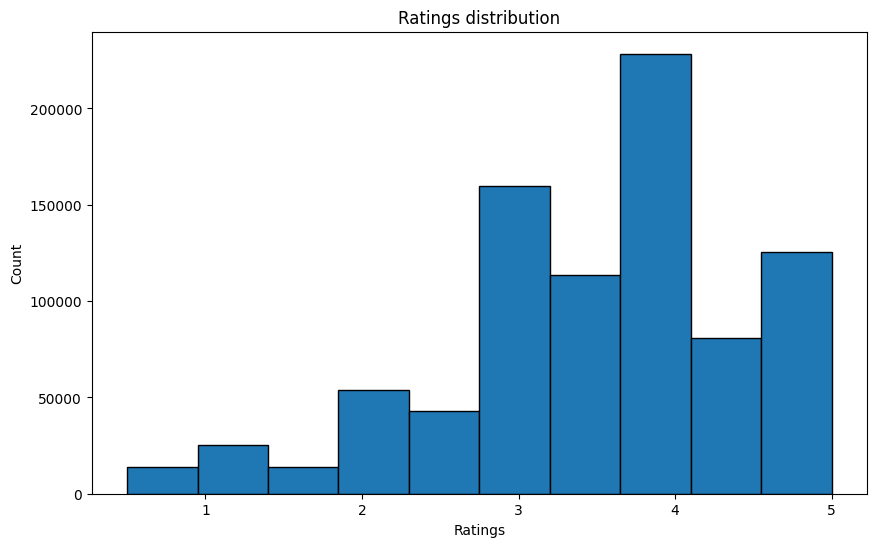

In [4]:
plot_data_item_distribution_as_hist(indexed_data)

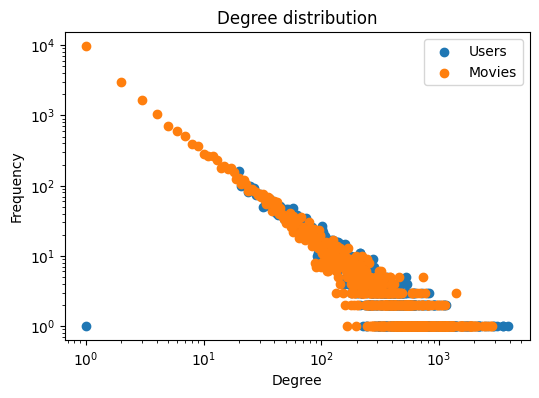

In [5]:
plot_power_low_distribution(
    indexed_data,
)

In [6]:
als_instance = AlternatingLeastSquares(
    hyper_lambda=settings.als.HYPER_LAMBDA,
    hyper_gamma=settings.als.HYPER_GAMMA,
    hyper_tau=settings.als.HYPER_TAU,
    hyper_n_epochs=settings.als.HYPER_N_EPOCH,
    hyper_n_factors=settings.als.HYPER_N_FACTOR,
)

als_backend = Backend(
    # Define the algorithm
    algorithm=als_instance,
    checkpoint_manager=CheckpointManager(
        checkpoint_folder=settings.als.CHECKPOINT_FOLDER,
        sub_folder=str(settings.general.LINES_COUNT_TO_READ),
    ),
    # The predictor needs this to render the name of the items
    item_database=item_database,
    # Whether we should resume by using the last state of
    # the algorithm the checkpoint manager folder or not.
    resume=True,
)

In [7]:
recommender_builder = CollaborativeFilteringRecommenderBuilder(
    backend=als_backend,
)

# This might take some moment before finishing
recommender = recommender_builder.build(data=indexed_data)

2025-01-06 03:54:16,404 [INFO] Starting the build of the recommender using AlternatingLeastSquares...
2025-01-06 03:54:16,408 [INFO] Starting a model fitting using the backend AlternatingLeastSquares...
2025-01-06 03:54:16,414 [INFO] Checkpoint ./artifacts/checkpoints/als/1000000/20250106-035211_lambda0.1_gamma0.01_tau1_n_epochs4_n_factors10.pkl loaded with success
2025-01-06 03:54:16,415 [INFO] All factors and biases are already provided, so no initialization is needed.


Epochs:  25%|██▌       | 1/4 [00:15<00:46, 15.65s/epoch]

Epoch 1/4: Loss (Train/Test) : -25590.4915/-104631.4615, RMSE (Train/Test) : 0.7081/3.7534


Epochs:  50%|█████     | 2/4 [00:32<00:32, 16.29s/epoch]

Epoch 2/4: Loss (Train/Test) : -25463.1531/-104687.0684, RMSE (Train/Test) : 0.7049/3.7532


Epochs:  75%|███████▌  | 3/4 [00:47<00:15, 15.72s/epoch]

Epoch 3/4: Loss (Train/Test) : -25435.7851/-104635.2498, RMSE (Train/Test) : 0.7041/3.7518


Epochs: 100%|██████████| 4/4 [01:02<00:00, 15.58s/epoch]

Epoch 4/4: Loss (Train/Test) : -25424.6940/-104550.2426, RMSE (Train/Test) : 0.7038/3.7501
2025-01-06 03:55:18,775 [INFO] Checkpoint successfully saved at 20250106-035518_lambda0.1_gamma0.01_tau1_n_epochs4_n_factors10
2025-01-06 03:55:18,776 [INFO] Successfully built the recommender using AlternatingLeastSquares


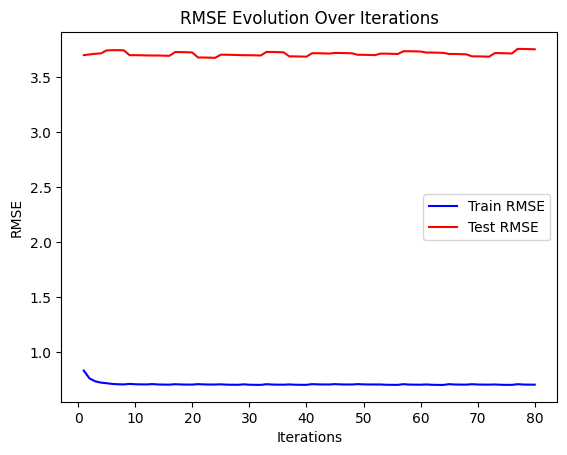

In [8]:
plot_als_train_test_rmse_evolution(als_backend.algorithm)

In [10]:
prediction_input = [("17", 4)]
recommender.recommend(prediction_input)

[{'title': 'Back To The Sea (2012)', 'genres': 'Animation|Children'},
 {'title': 'Jeffrey Dahmer Files, The (2012)', 'genres': 'Crime|Documentary'},
 {'title': 'Afflicted, The (2010)', 'genres': 'Horror|Thriller'},
 {'title': 'The Last House on the Beach (1978)',
  'genres': 'Crime|Drama|Horror|Thriller'},
 {'title': 'Paradise (1982)', 'genres': 'Adventure|Romance'},
 {'title': 'Cyrus: Mind of a Serial Killer (2010)',
  'genres': 'Crime|Horror|Mystery|Thriller'},
 {'title': 'Town That Dreaded Sundown, The (1976)',
  'genres': 'Crime|Drama|Horror|Mystery|Thriller'},
 {'title': 'Story of G.I. Joe (1945)', 'genres': 'War'},
 {'title': 'In Old California (1942)', 'genres': 'Western'},
 {'title': 'Love in Bloom (1935)', 'genres': 'Romance'}]